Covid-19_and_Pneumonia_X-Ray_Detector

In [8]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
import cv2
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Load, scale and prepare train sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [6]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa

In [15]:
# resNet50
# from tensorflow.keras.applications.resnet50 import ResNet50
# ModuleNotFoundError: No module named 'tensorflow.keras.application'

# Functions

In [7]:
def listdir_nohidden(path):
  """ returns a list of no hidden folders in a path
  in this case the folders are sorted as the are classes of a images
  (and later will be used as an iterator...)"""
  # import os

  folders = []
  for f in os.listdir(path):
    if not f.startswith('.'):
      # yield f # returns a generator (iterable)
      folders += [f]
  return sorted(folders)


In [8]:
def plot_metric(history, metric):
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set
    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.yscale('log')
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# Description

### Identify COVID by x-RAy  
Dectect and classify chest illneses.  
Reduce costs and detection time.  
Have a pre-diagnosis in minutes. Increase survival rate.  
Categories:  
* Healthy
* Covid-19
* Bacterial Pneumonia
* Viric Pneumonia   


### Data info
custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.Each class contains 133 images.  
  
data from https://github.com/ieee8023/covid-chestxray-dataset and https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.  
created by frogames.    

0 - Covid-19

1 - Normal X-ray

2 - Viral Pneumonia X-ray

3 - Bacterial Pneumonia X-ray


# Load Data

In [9]:
# !!! change dir
# allows to work with relative paths in all the notebook
os.chdir('/content/drive/MyDrive/ironhack-finalProject')

In [10]:
train_path = 'data_train'

In [20]:
# Scan folders in train_path
# os.listdir(train_path)
listdir_nohidden(train_path)

['0', '1', '2', '3']

In [21]:
image_generator = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2)

In [22]:
# Question 
# ??? rescale --> I think it min_max_scale the values of the pixels in the image
# between 0 and 1


In [23]:
train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "training")

Found 428 images belonging to 4 classes.


In [24]:
# Question
# !!! flow_from_directory Deprecated?
# classes?

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [25]:
# test_path = '/content/drive/MyDrive/ironhack-finalProject/data_test'

In [26]:
# Define validation subset
# After validation split en image_generator
train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "validation")

Found 104 images belonging to 4 classes.


In [27]:
# 133*4, 133*4*0.8, 133*4*0.2

In [28]:
train_images, train_labels = next(train_generator)

In [29]:
# Question
# ??? next?
# https://datascience.stackexchange.com/questions/88737/keras-next-what-does-2-256-128-128-3-mean

In [30]:
train_images.shape

(40, 256, 256, 3)

In [31]:
train_labels.shape

(40, 4)

In [32]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [33]:
# We are assuming that is not possible to have two illneses at the same time

In [34]:
label_names = {0:'covid', 1:'normal', 2: 'viral', 3:'bacterial'}

# Visualize images

In [35]:
#L = 6
#W = 6
#range(L*W)

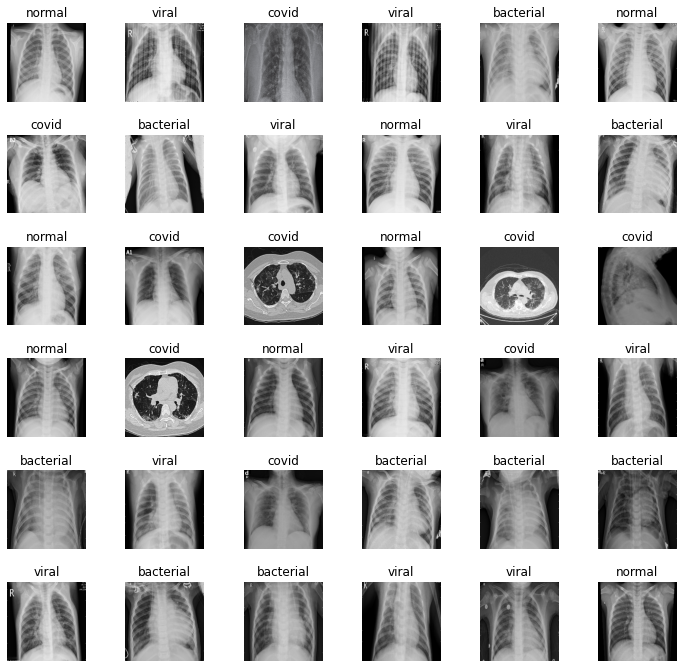

In [36]:
# Create matrix of images
L = 6
W = 6

fig, ax = plt.subplots(L, W, figsize = (12,12))
ax = ax.ravel() # it flattens the axes and allows to make a for loop

for i in range(L*W):
  ax[i].imshow(train_images[i])
  ax[i].set_title(label_names[np.argmax(train_labels[i])])
  ax[i].axis('off')

plt.subplots_adjust(wspace=0.5)

In [37]:
# 120*5*5

# Build the CNN 0

## Convolutional architecture

In [38]:
# Initialize the CNN
cls = Sequential()

In [39]:
# Add Convolution Layer
# cls.add(Conv2D(32, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))
cls.add(Conv2D(9, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))

In [40]:
# classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# input shape necessary when not all the pictures are squared.

In [41]:
# Question
# ??? padding, --> acolchado/ relleno en el input. if padding "same" and strides = 1
# then input size and output size will be the same
# ??? strides, --> zancadas o avances. i.e [i,2,2,1] (if window 2x2 no overlaping)
# ??? dilation_rate...

In [42]:
# Add Max Pooling (spatial subsampling)
# Very important define well the pool_size
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))

In [43]:
# average pooling 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D

In [44]:
# Flattening
cls.add(Flatten())

## Fully-connected layers

In [45]:
# Dense Layers
#cls.add(Dense(units = 256, activation = 'relu'))
#cls.add(Dense(units = 128, activation = 'relu'))
cls.add(Dense(units = 64, activation = 'relu'))


In [46]:
# Dropout Layers
cls.add(Dropout(0.2, seed = 0))

In [47]:
# Classification Layer
cls.add(Dense(units = 4, activation = 'softmax'))

In [48]:
# 84/120

In [49]:
# ??? How long is the flaten layer?
# units --> positive integer, dimensionality of the output space

In [50]:
# 256*2

## Compile CNN

In [51]:
cls.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics=['accuracy'])

In [52]:
# Question
# compile --> monta la estructura y el optimizador
# el optimizador busca los mejores pesos para conseguir que la función de loss 
# sea lo más pequeña posible. Y la función de loss depende las funciones de activacion



In [53]:
#cls.summary()

In [54]:
cls.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 9)       684       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 9)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 9)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35721)             0         
                                                                 
 dense (Dense)               (None, 64)                2286208   
                                                                 
 dropout (Dropout)           (None, 64)                0

## define callbacks

In [55]:
# Define callbacks

In [56]:
checkpoint_path = 'models/cnn_cls.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_freq='epoch', # How often the checkpoint file will be saved.
    save_weights_only=False, # Wether or not to save just the weitgths of each neuron.
    save_best_only = True, 
    # it only saves when the model is considered the "best" and the latest 
    # best model according to the quantity monitored will not be overwritten
    verbose=1 # To display the progress
)

In [57]:
early_stopping = EarlyStopping(monitor = "val_loss", mode = 'min',
                               patience=20, verbose=1) 


# Train and validation.  
Different batch size

In [58]:
# generate the train and test with different batch size
train_generator = image_generator.flow_from_directory(batch_size = 4,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "training")

Found 428 images belonging to 4 classes.


In [59]:
val_generator = image_generator.flow_from_directory(batch_size = 4,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "validation")

Found 104 images belonging to 4 classes.


# fit_generator train_data

In [60]:
history = cls.fit_generator(
    train_generator, 
    validation_data=val_generator,
    steps_per_epoch= train_generator.n//4,
    epochs=30, # Number of epochs. 
    #validation_split=0.20, # Here the TRAIN set will be split in TRAIN = TRAIN_NEW + VALIDATION. TRAIN_NEW used 
    # for train and val for CV
    #batch_size=20, # How many samples to input in the network before updating the weights
    #verbose=2, # To display the progress.
    callbacks=[early_stopping,checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
107/107 [==============================] - ETA: 0s - loss: 1.6163 - accuracy: 0.5280
Epoch 1: val_loss improved from inf to 0.67786, saving model to models/cnn_cls.hdf5
107/107 [==============================] - 120s 1s/step - loss: 1.6163 - accuracy: 0.5280 - val_loss: 0.6779 - val_accuracy: 0.8750
Epoch 2/30
107/107 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8248
Epoch 2: val_loss improved from 0.67786 to 0.42723, saving model to models/cnn_cls.hdf5
107/107 [==============================] - 27s 256ms/step - loss: 0.4890 - accuracy: 0.8248 - val_loss: 0.4272 - val_accuracy: 0.9038
Epoch 3/30
107/107 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8832
Epoch 3: val_loss improved from 0.42723 to 0.40486, saving model to models/cnn_cls.hdf5
107/107 [==============================] - 27s 257ms/step - loss: 0.3194 - accuracy: 0.8832 - val_loss: 0.4049 - val_accuracy: 0.8942
Epoch 4/30
107/107 [==============================] 

In [61]:
# Steps per epoch: images in data_train (train_generator) / batch size

# Evaluate Model

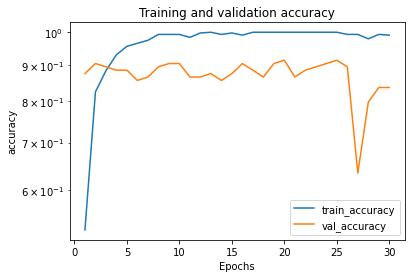

In [62]:
plot_metric(history, 'accuracy')

# Generate Test Set

In [13]:
test_path = 'data_test'

In [14]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [15]:
test_generator = test_gen.flow_from_directory(directory=test_path,
                                              target_size = (256,256),
                                              class_mode = "categorical",
                                              batch_size=4,
                                              shuffle=True,
                                              seed = 0,
                                              )

Found 40 images belonging to 4 classes.


# Evaluate Test

In [67]:
evaluate = cls.evaluate_generator(test_generator, 
                                  steps = test_generator.n//4,
                                  verbose = 1)

print('Accuracy in test: {}'.format(evaluate[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


10/10 [==============================] - 10s 1s/step - loss: 1.5758 - accuracy: 0.6750
Accuracy in test: 0.675000011920929


In [68]:
evaluate

[1.5757520198822021, 0.675000011920929]

# Confusion Matrix

In [69]:
# from sklearn.metrics import...

prediction = []
original = []
image = []


for i in range(len(listdir_nohidden(test_path))):
  for item in os.listdir(os.path.join(test_path, str(i))):
    img = cv2.imread(os.path.join(test_path, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img/255 # manually scale between 0 and 1
    img = img.reshape(-1, 256, 256, 3) # our CNN was trained with batchs
    predict = cls.predict(img) # just predict 
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [70]:
len(original)

40

In [ ]:
#len(listdir_nohidden(test_path))

In [71]:
score = accuracy_score(original, prediction)
print('Accuracy on prediction{}'.format(score))

Accuracy on prediction0.725


In [72]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.60      0.60      0.60        10
           2       0.70      0.70      0.70        10
           3       0.75      0.60      0.67        10

    accuracy                           0.73        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.72      0.72      0.72        40



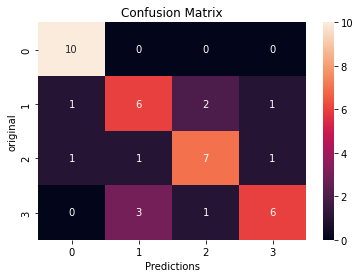

In [73]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predictions')
ax.set_ylabel('original')
ax.set_title('Confusion Matrix')
plt.show()


# Load checkpoint model

In [12]:
#from keras.saving.hdf5_format import load_model_from_hdf5
#loaded_model = load_model_from_hdf5
loaded_model = load_model('models/cnn_cls.hdf5')

In [17]:
# Evaluate loaded_model
evaluate_loaded = loaded_model.evaluate_generator(test_generator, 
                                  steps = test_generator.n//4,
                                  verbose = 1)

print('Accuracy in test: {}'.format(evaluate_loaded[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


10/10 [==============================] - 2s 155ms/step - loss: 0.8816 - accuracy: 0.7000
Accuracy in test: 0.699999988079071


In [19]:
loaded_gen = ImageDataGenerator(rescale = 1./255)

In [21]:
loaded_generator = test_gen.flow_from_directory(directory=test_path,
                                              target_size = (256,256),
                                              class_mode = "categorical",
                                              batch_size=40, # !!!
                                              shuffle=True,
                                              seed = 0,
                                              )

Found 40 images belonging to 4 classes.


In [22]:
test_images, test_labels = next(loaded_generator)

In [23]:
test_images.shape

(40, 256, 256, 3)

In [25]:
import tensorflow.keras.backend as K


In [26]:
test_images_t = K.constant(test_images)

In [27]:
test_images_t.shape

TensorShape([40, 256, 256, 3])

In [28]:
loaded_model.call(test_images_t)

<tf.Tensor: shape=(40, 4), dtype=float32, numpy=
array([[5.56834042e-04, 4.74723548e-01, 5.02153695e-01, 2.25659590e-02],
       [2.58534601e-05, 1.50391145e-03, 9.83091295e-01, 1.53789697e-02],
       [6.75807655e-01, 4.36451994e-02, 2.27920443e-01, 5.26267700e-02],
       [9.98728931e-01, 1.16802880e-03, 9.96063609e-05, 3.33963089e-06],
       [1.20053755e-03, 5.19946851e-02, 1.00787193e-01, 8.46017599e-01],
       [4.37108099e-01, 3.97945911e-01, 7.69416988e-03, 1.57251880e-01],
       [7.75668377e-05, 9.96194601e-01, 4.58444410e-04, 3.26945493e-03],
       [2.91462970e-06, 9.99734700e-01, 9.83190039e-05, 1.64150697e-04],
       [1.54192632e-04, 9.98735845e-01, 6.40088809e-04, 4.69916442e-04],
       [1.96023611e-03, 3.08854668e-03, 4.65758257e-02, 9.48375404e-01],
       [4.33991008e-05, 1.02851295e-03, 9.96500134e-01, 2.42794096e-03],
       [1.58814285e-02, 2.76544392e-02, 8.74091163e-02, 8.69054973e-01],
       [2.52176716e-04, 8.07473242e-01, 9.10000689e-03, 1.83174580e-01],
  

In [32]:
loaded_model.call(test_images_t).numpy()[0]

array([0.00055683, 0.47472355, 0.5021537 , 0.02256596], dtype=float32)

In [33]:
len(loaded_model.call(test_images_t).numpy())

40

In [36]:
loaded_pred = loaded_model.call(test_images_t).numpy()

In [37]:
loaded_pred = [np.argmax(loaded_pred[x]) for x in range(len(loaded_pred))]
loaded_pred

[2,
 2,
 0,
 0,
 3,
 0,
 1,
 1,
 1,
 3,
 2,
 3,
 1,
 0,
 1,
 1,
 3,
 3,
 1,
 0,
 1,
 0,
 1,
 1,
 3,
 0,
 2,
 0,
 1,
 1,
 3,
 2,
 0,
 2,
 2,
 1,
 0,
 3,
 0,
 0]

In [40]:
test_true = [np.argmax(test_labels[x]) for x in range(len(test_labels))]
test_true

[2,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 3,
 0,
 3,
 3,
 3,
 1,
 3,
 0,
 1,
 0,
 1,
 1,
 3,
 0,
 3,
 0,
 2,
 1,
 3,
 2,
 0,
 2,
 2,
 1,
 0,
 3,
 0,
 0]

In [41]:
print(classification_report(np.asarray(test_true), np.asarray(loaded_pred)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.54      0.70      0.61        10
           2       0.86      0.60      0.71        10
           3       0.62      0.50      0.56        10

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.69        40
weighted avg       0.71      0.70      0.69        40



In [ ]:
# Is it different the model saved from the model in the notebook?